## Laboratory 4: Simulation of a Spin-Based Quantum Reservoir Computer for time-series prediction

### 1 - Introduction

Quantum Reservoir Computing (QRC) is a paradigm that extends reservoir computing to quantum systems. A fixed (non-variational) quantum dynamical system acts as a reservoir that processes time-dependent inputs through its temporal evolution, while learning is restricted to a classical readout layer. This approach avoids training the internal quantum dynamics and makes QRC particularly suitable for near-term quantum devices (NISQ).

In spin-based QRC, the reservoir consists of interacting spins evolving under a fixed Hamiltonian. Classical inputs are injected sequentially by encoding them into the quantum state of boundary spins, which interact with the reservoir. This procedure induces an effective open-system dynamics that provides both nonlinearity and memory, key properties for time-series processing.

In this laboratory, you will simulate a spin-based quantum reservoir computer for time-series prediction. You will implement amplitude encoding of inputs, simulate the density-matrix evolution of the reservoir, and extract classical features from quantum measurements. A linear readout will then be trained to predict future values of a temporal signal (a chaotic time series from the Lorenz System).

The objective of this lab is to understand how quantum dynamics, input encoding, and measurement combine to produce computational capabilities, and to gain hands-on experience with the simulation and evaluation of a quantum reservoir computing systems.

### 2 - Spin-based Quantum Reservoir Computing Modelling

To simulate the quantum reservoir computer, We will uses an Hamiltonian describing interactions between spins (similar to that present in class) and following the mathematical form highlighted in the following reference : ***Quantum reservoir computing: a reservoir approach toward quantum machine learning on near-term quantum devices***: https://arxiv.org/abs/2011.04890

The mathemetical form of the hamiltonian reads :

$$H = \sum_{i,j} J_{i,j} X_i X_j + h \sum_i Z_i$$

with $X_i = I \otimes I ... \otimes I \otimes X \otimes I ... \otimes I$, $X$ the Pauli-X operator, and $I$ the identity operator acting on a single qubit.

For example, Consideriong a QRC with two nodes, we would have :
- $X_0 = X \otimes I$
- $X_1 = I \otimes X$

 ## Work to do

### 3-Implementation Of Operators

***Question 1*** :   Create in Numpy the matrices for the $X$, $Y$, $Z$  Pauli operators and $I$ the identity operator.

In [3]:
import numpy as np

In [4]:
# TODO Create the matrices for the X, Y, Z  Pauly gates and I the identity in Numpy.
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

***Question 2*** :  Create in Numpy the matrices for operators $X_i$, $Z_i$.

In [5]:
# TODO return the numpy version of Xi
def Xi(nb_node, i):
    """
    Returns the matrix for the Pauli-X operator on the i-th qubit
    in a system of nb_node qubits.
    """
    # 1. Create a list of Identity operators for all nodes
    op_list = [I] * nb_node
    
    # 2. Replace the operator at index 'i' with X
    op_list[i] = X
    
    # 3. Compute the tensor product of the whole list sequentially
    res = op_list[0]
    for k in range(1, nb_node):
        res = np.kron(res, op_list[k])
        
    return res

In [ ]:
# TODO return the numpy version of Zi
def Zi(nb_node, i):
    """
    Returns the matrix for the Pauli-Z operator on the i-th qubit
    in a system of nb_node qubits.
    """
    # 1. Create a list of Identity operators for all nodes
    op_list = [I] * nb_node
    
    # 2. Replace the operator at index 'i' with Z
    op_list[i] = Z
    
    # 3. Compute the tensor product of the whole list sequentially
    res = op_list[0]
    for k in range(1, nb_node):
        res = np.kron(res, op_list[k])
        
    return res

***Question 3*** :   Create in Numpy the matrix for the Hamiltonian operator using the expression shown in Section 2. The interaction being bidirectional, the adjacency of matrix of the network containing coefficient $J_{i,j}$ is squared and symmetric (Note : the transverse field coefficients $h$ are on the diagonal on matrix).

***Note*** : $weight[i,j] = J_{i,j} = J_{j,i} = weight[j,i]$, the weight matrix is symmetric, so it is not necessary to traverse the entire matrix, but only the upper or lower triangular part.

In [8]:
# TODO return the numpy Hamiltonian for the given weigth
def make_Hamiltonian(nb_node, weight):
    res = np.zeros((2**nb_node, 2**nb_node))
    for i in range(nb_node):
        res += weight[i, i] * Zi(nb_node, i)
        for j in range(i + 1, nb_node):
            res += weight[i, j] * Xi(nb_node, i) @ Xi(nb_node, j)
    return res

In [9]:
make_Hamiltonian(2, np.array([[1.0,0.2], [0.2,1.0]]))

array([[ 2. +0.j,  0. +0.j,  0. +0.j,  0.2+0.j],
       [ 0. +0.j,  0. +0.j,  0.2+0.j,  0. +0.j],
       [ 0. +0.j,  0.2+0.j,  0. +0.j,  0. +0.j],
       [ 0.2+0.j,  0. +0.j,  0. +0.j, -2. +0.j]])

### 4- Data input

The following code allows to easily compute the partial trace for an operator. This will be a useful function for the computation of the temporal evolution of the density operator describiung aggregated state of the reservoir and boundary input qubits 

In [10]:
# https://github.com/cvxpy/cvxpy/issues/563#issuecomment-414081249

def partial_trace(rho, dims, axis=0):
    """
    Takes partial trace over the subsystem defined by 'axis'
    rho: a matrix
    dims: a list containing the dimension of each subsystem
    axis: the index of the subsytem to be traced out
    (We assume that each subsystem is square)
    """
    dims_ = np.array(dims)
    # Reshape the matrix into a tensor with the following shape:
    # [dim_0, dim_1, ..., dim_n, dim_0, dim_1, ..., dim_n]
    # Each subsystem gets one index for its row and another one for its column
    reshaped_rho = rho.reshape(np.concatenate((dims_, dims_), axis=None))

    # Move the subsystems to be traced towards the end
    reshaped_rho = np.moveaxis(reshaped_rho, axis, -1)
    reshaped_rho = np.moveaxis(reshaped_rho, len(dims)+axis-1, -1)

    # Trace over the very last row and column indices
    traced_out_rho = np.trace(reshaped_rho, axis1=-2, axis2=-1)

    # traced_out_rho is still in the shape of a tensor
    # Reshape back to a matrix
    dims_untraced = np.delete(dims_, axis)
    rho_dim = np.prod(dims_untraced)
    return traced_out_rho.reshape([rho_dim, rho_dim])

***Question 4*** :  We will inject the normalized data $x$ by replacing a node values with $\frac{I + (2x-1)Z}{2}$. Return the matrix corresponding to the normalized data x

In [11]:
# TODO return the matrix corresponding to the normalized data x
def input_matrix(one_dim_data):
    return (I + (2 * one_dim_data - 1) * Z) / 2

***Question 5*** : To replace the node values with new ones, we extract the values of the nodes we want to keep using the partial trace. Then we perform a tensorial product with the matrices of the new values.

In [12]:
# TODO input_data take the density matrix and replace the node value by the new input
def input_data(nb_node, density_matrix, multi_dim_data):
    """
    Updates the density matrix by replacing the state of the first k nodes
    with the encoded states of multi_dim_data, where k = len(multi_dim_data).
    """
    num_inputs = len(multi_dim_data)

    rho_kept = density_matrix
    current_dims = [2] * nb_node
    
    for _ in range(num_inputs):
        rho_kept = partial_trace(rho_kept, current_dims, axis=0)
        current_dims.pop(0)
        
    rho_in = input_matrix(multi_dim_data[0])
    
    for i in range(1, num_inputs):
        rho_in = np.kron(rho_in, input_matrix(multi_dim_data[i]))
        
    new_density_matrix = np.kron(rho_in, rho_kept)
    
    return new_density_matrix

In [13]:
density_matrix = np.zeros((2**3, 2**3))
density_matrix[0,0] = 1
input_data(3, density_matrix, [0.1, 0.2])

array([[0.02+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.08+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.18+0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.72+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j]])

### 5 - Observable

***Question 6*** : We will recover the values of the observables $Z_i$ renormalized between 0 and 1 as observables.

In [14]:
# TODO observable return the Zi observable values
def observable(nb_node, density_matrix):
    """
    Computes the expectation value of Zi for each node,
    renormalized to the range [0, 1].
    """
    res = []
    for i in range(nb_node):
        # 1. Construct the operator Zi
        op_Zi = Zi(nb_node, i)
        
        # 2. Compute Expectation Value <Zi> = Tr(rho * Zi)
        # Note: We take the real part because the observable is Hermitian
        expectation_val = np.real(np.trace(density_matrix @ op_Zi))
        
        # 3. Renormalize from [-1, 1] to [0, 1]
        normalized_val = (expectation_val + 1) / 2
        res.append(normalized_val)
        
    return np.array(res)

### 6 - Reservoir Evolution

In [15]:
from scipy.linalg import expm # Do the exponentielle of matrix

We are now going to evolve our reservoir.

To do this, we will follow these steps:
- We inject the data in the density_matrix with ```input_data``` function.
- We make the reservoir evolve during a time $t$ with the Schrödinger equation.
- We stock the observable as results.
- We start again with the next piece of data.

-------------------------------------------

For a density matrix $\rho$ and a time-independent Hamiltonian $H$, the Schrödinger equation describing the evolution of the system over a time period $t$ is as follows:

$\rho' = \exp(-iHt) \rho \exp(-iHt)$

-------------------------------------------

In addition to all this, we will introduce the concept of virtual nodes:
We measure our system several times between two injections. So instead of evolving our system for a period of time $t$ after injecting the data, we evolve it as many times as there are virtual nodes $nb\_virtual\_node$ for a period of time $t/nb\_virtual\_node$.


***Question 7*** : Implement the evolution of the reservoir.

In [16]:
def Reservoir(nb_node, weight, data, t=1.0, nb_virtual=10):

    # TODO Make a reservoir Hamiltonian
    H = make_Hamiltonian(nb_node, weight)

    dt = t / nb_virtual
    U = expm(-1j * H * dt)
    U_dagger = U.conj().T

    # Initialize the density matrix
    density_matrix = np.zeros((2**nb_node, 2**nb_node))
    density_matrix[0,0] = 1

    # List of results
    res = []

    for x in data:
        # List of virtual nodes
        aux=[]
        # TODO inject the data x in the density matrix
        density_matrix = input_data(nb_node, density_matrix, x)
        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U @ density_matrix @ U_dagger

            # TODO calculate the observables and store them in the virtual node list
            obs = observable(nb_node, density_matrix)
            aux.extend(obs)

        res.append(aux)
    return np.array(res)

### 7 - A first test: Lorenz attractor

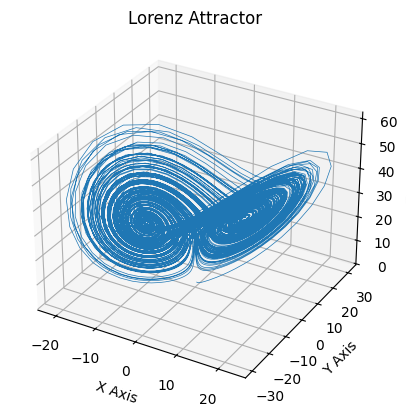

In [17]:
import matplotlib.pyplot as plt

# https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.02
num_steps = 11000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

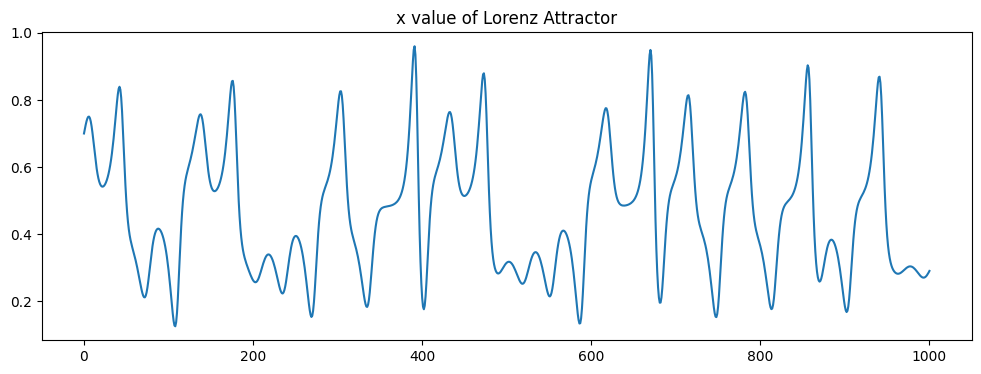

In [18]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
xyzs = min_max_scaler.fit_transform(xyzs)
x_value = xyzs[:,0].reshape(-1, 1)
plt.subplots(figsize=(12, 4))
plt.title("x value of Lorenz Attractor")
plt.plot(x_value[10000:], label='x')

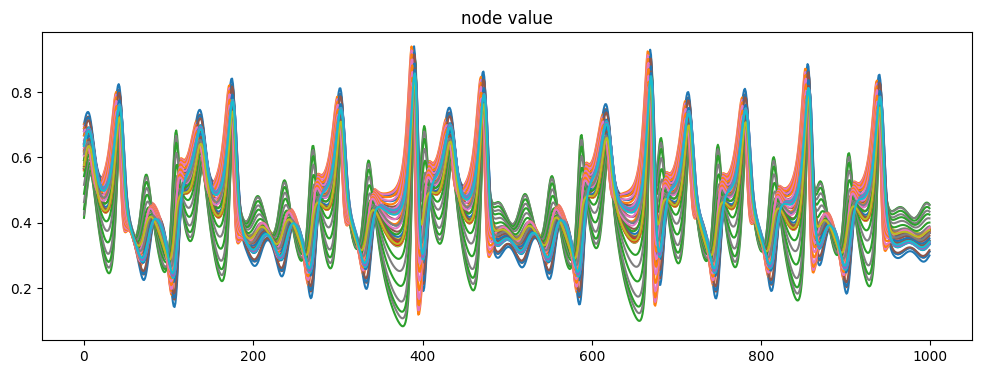

In [19]:
# generate random weight for the reservoir
def generated_reservoir_weights(nb_node):
    X = np.random.rand(nb_node, nb_node) - 0.5
    X = (X + X.T)/2
    X[np.diag_indices_from(X)] = np.ones(nb_node)
    return X

weigth_reservoir = generated_reservoir_weights(5)

embedded_data = Reservoir(5, weigth_reservoir, xyzs, t=4.0)
plt.subplots(figsize=(12, 4))
plt.title("node value")
plt.plot(embedded_data[-1000:,:])

### 8 - prediction without reservoir: Lorenz attractor

In [20]:
# calculPseudoInverse calculate the pseudo inverse matrix (linear regression) y = x*W
def calculPseudoInverse(x,y):
    Xinv = np.linalg.pinv(x)
    Y = np.array(y)
    return np.matmul(Xinv, Y)

Here is an example where we use the first 10,000 data points to obtain the W matrix where $xyzs_{k+1} = xyzs{k}*W$. We then use the matrix to predict the last 1,000 steps.

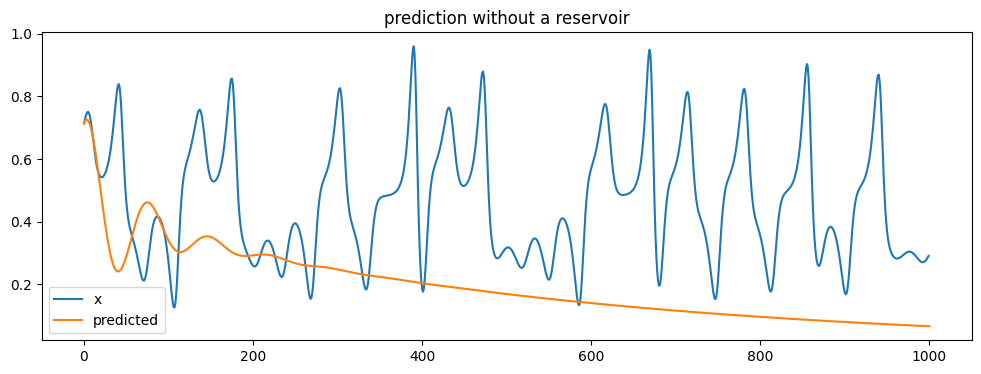

In [21]:
steps = 1000 # number of steps to predict
weights = calculPseudoInverse(xyzs[:-1*steps-1,:], xyzs[1:-1*steps,:])
x_predict = [xyzs[-1*steps,:]]
for i in range(steps):
    x_predict.append(np.matmul(x_predict[-1], weights))
x_predict = np.array(x_predict)

plt.subplots(figsize=(12, 4))
plt.title("prediction without a reservoir")
plt.plot(x_value[-1*steps:], label='x')
plt.plot(x_predict[:,0], label='predicted')
plt.legend()

### 9 - prediction with reservoir: Lorenz attractor

#### 9-1 Prediction 1-steps

***Question 8*** : Here we will test the short-term prediction capability. We will pass our entire time series through the reservoir, then use the first 10,000 points to perform a linear regression $xyzs_{k+1} = reservoir(xyzs_{k}) * W $ then use the $W$ weigth to see the prediction for the last 1,000 points. Basically, we predict the next point each time based on the true sequence.

In [ ]:
# 1. Run the reservoir on the full dataset
# (This simulates the quantum dynamics for the whole sequence)
reservoir_result = Reservoir(5, weigth_reservoir, xyzs, t=4.0)

# Define the split point for training
split_point = 10000

# 2. Prepare Training Data
# Input: Reservoir states for steps 0 to 9999
X_train = reservoir_result[:split_point]
# Target: Lorenz values for steps 1 to 10000 (the "next" values)
Y_train = xyzs[1:split_point+1]

# 3. Calculate the linear regression weights
# Y = X * W  =>  W = pinv(X) * Y
weights = calculPseudoInverse(X_train, Y_train)

# 4. Predict the last section (Testing)
# We use the reservoir states from the split point onwards to predict the next steps
# Inputs: reservoir_result[10000] to reservoir_result[end-1]
# Targets: xyzs[10001] to xyzs[end]
X_test = reservoir_result[split_point:-1]
x_predict = np.matmul(X_test, weights)

# 5. Plotting
plt.subplots(figsize=(12, 4))
plt.title("Short-term prediction (1-step ahead)")

# Plot the ground truth (x_value is the first column of xyzs)
# We use -len(x_predict) to align exactly with the number of predictions made
plt.plot(x_value[-len(x_predict):], label='Ground Truth (x)')

# Plot the predictions
# x_predict contains [x, y, z], we plot column 0
plt.plot(x_predict[:, 0], label='Predicted (Linear Regression)', linestyle='--')

plt.legend()
plt.show()

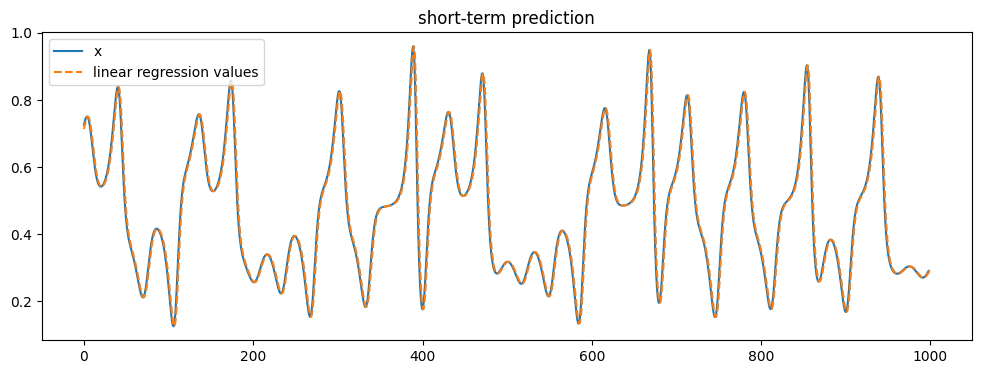

In [32]:
reservoir_result = Reservoir(5, weigth_reservoir, xyzs, t=4.0)

# TODO calcul the Pseudo Inverse (linear regression) as in the previous example (use the first 10,000 data points to calculate the weights)
split_point = 10000
X_train = reservoir_result[:split_point]
Y_train = xyzs[1:split_point+1]

weights = calculPseudoInverse(X_train, Y_train)

X_test = reservoir_result[split_point:-1]

# TODO predict the last 1000 points
x_predict = np.matmul(X_test, weights)


plt.subplots(figsize=(12, 4))
plt.title("short-term prediction")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(x_predict[:, 0], label='linear regression values', linestyle='--')
plt.legend()

#### 9-2 Prediction N-steps

***Question 9*** : Now we want to use the first 10,000 data points in the sequence to determine $W$, then we will use the formula  $xyzs_{k+1} = reservoir(xyzs_{k}) * W $ to predict $xyzs_{k+1}$ and then inject it into the reservoir, and so on. We are making a long-term prediction.

In [29]:
def predict(nb_node, weigth, list_of_data, steps, t=1.0, nb_virtual=10):

    # TODO Make a reservoir Hamiltonian
    H = make_Hamiltonian(nb_node, weigth)
    dt = t / nb_virtual
    U = expm(-1j * H * dt)
    U_dagger = U.conj().T

    # Initialize the density matrix
    density_matrix = np.zeros((2**nb_node, 2**nb_node))
    density_matrix[0,0] = 1

    # List of results
    res = []

    for x in list_of_data:
        # List of virtual nodes
        aux=[]
        # TODO inject the data x in the density matrix
        density_matrix = input_data(nb_node, density_matrix, x)

        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U @ density_matrix @ U_dagger


            # TODO calculate the observables and store them in the virtual node list
            aux.extend(observable(nb_node, density_matrix))

        res.append(aux)
    res = np.array(res)

    # TODO calcul the Pseudo Inverse Matrix (linear regression)
    res = np.array(res)
    X_train = res[:-1]
    Y_train = list_of_data[1:]
    weights = calculPseudoInverse(X_train, Y_train)


    # TODO predict the initial new data
    new_data = []

    current_pred = res[-1] @ weights
    new_data.append(current_pred)
    
    for i in range(steps):
        aux=[]
        # TODO inject the last data predicted in the density matrix
        density_matrix = input_data(nb_node, density_matrix, current_pred)

        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U @ density_matrix @ U_dagger

            # TODO calculate the observables and store them in the virtual node list
            aux.extend(observable(nb_node, density_matrix))

        # TODO Using the new result from the reservoir and the previously calculated weights, predict the new value.
        #      And added it to the new_data list
        feature_vector = np.array(aux)
        next_val = feature_vector @ weights
        new_data.append(next_val)
        current_pred = next_val
        
    return np.array(new_data)

***Question 10*** : Predict the last n steps of the sequence and display them.

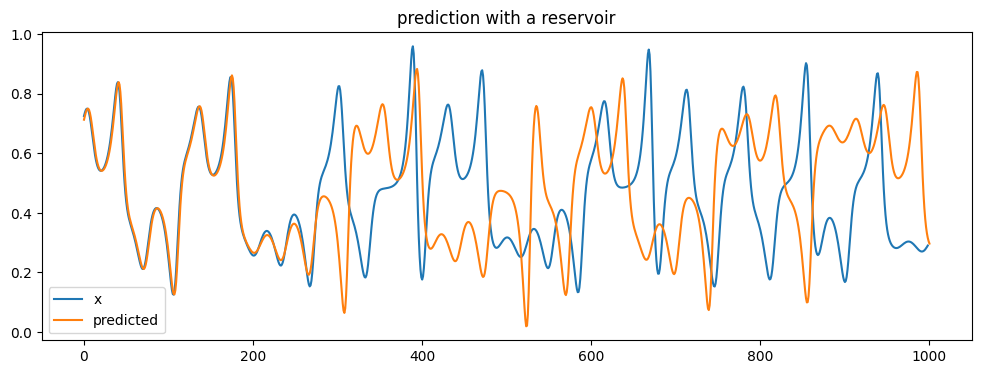

In [30]:
n_steps = 1000
new_data = predict(5, weigth_reservoir, xyzs[:-1*n_steps], n_steps, t=4.0)

plt.subplots(figsize=(12, 4))
plt.title("prediction with a reservoir")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(new_data[:, 0], label='predicted')
plt.legend()